## Industrial Machine Fault Detection using Deep Learning
### Machines: Pumps, motors, valves etc. 

### Training a MLP on MFCC features generated from equipment sound files

- Rajesh Siraskar | 22-May-2021
----
- V.2.0: Add predict
- V.2.1: Add seaborn plots with error bands
- V.2.2: Compact version. Move utilities to utilities.py 
----
- Load data
- Split into train/test
- Build MLP network architecture
- Compile network
- Train network

In [5]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Custom utilities
from utilities import *

%matplotlib inline

warnings.filterwarnings("ignore")

In [6]:
JSON_FILE = "audio_files/machine_features.json"
NUMBER_OF_CLASSES = 6 # Machine normal/abnormal
TRAIN_EPOCHS = 20

### Main function
- Network: 
    - 1 input  = Flatten 3-D numpy array and use only 2-Ds (mfcc and hop-length)
    - 3 hidden = 512 x 256 x 64. Activation = ReLU
    - 1 output = Number of classes (genres). 4 genres. Activation = softmax  
- Mini-batch
- Adam optimization
- Learning-rate=0.0001

In [7]:
### 1. Load data
X, y = load_data (json_file = JSON_FILE)


### 2. Split into train/test
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.3)

### 3. Build MLP network architecture
#     i/p, 3 hidden, o/p and all fully-connected (i.e. dense)
model = keras.Sequential([
    # Input layer: 
    #   input json is a 3D file: We ignore 1st dim and consider only 2nd and 3rd dims
    #   MFCC for each segment, and each mfcc is a vector over an interval = hop-length
    #   - dimension 1: num_segments x n_classes x .wav-files-per-class 
    #   - dimension 2: num_mfcc_vectors_per_segment = math.ceil(samples_per_segment/hop_length)
    #   - dimension 3: num_mfcc
    #   X.shape[1] = dim-2 and X.shape[2]=dim-2
    #   first-dim: interval = inputs.shape[1]
    #   second-dim: mfcc = inputs.shape[2]
    #   NOTE: inputs.shape[0] is the segment number and we are not passing that
    keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),
    
    # 1st hidden-layer:
    #   Use ReLU instead of sigmoid. Much faster.
    #   ReLU better convergence. Reduce likelihood of vanishing gradients
    #   Vanishing gradients: Multiply error by derivative of activation fn.
    #   Sigmoid fn. derivative = 0.25. Keep multiplying by 0.25, gradient becomes smaller and smaller
    #   and *vanishes*
    keras.layers.Dense(512, activation="relu"),
    
    # 2nd hidden-layer:
    keras.layers.Dense(256, activation="relu"),
    
    # 3rd hidden-layer:
    keras.layers.Dense(64, activation="relu"),
    
    # Output layer: NUMBER_OF_CLASSES = number of genres = 4
    #   activation fn. = softmax for normalizing prob. sum to 1.0 and enables us to pick max. prob.
    keras.layers.Dense(NUMBER_OF_CLASSES,  activation="softmax")
])


### 4. Compile network
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, 
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

model.summary()

## 5. Train network. 
#     Use min-batch. Other techniques
#     (1) Stochastic = Gradient on one sample, fast, inaccurate. 
#     (2) Full training set: Very accurate 
#     (3) Mini-batch: in-between

history = model.fit(X_train, y_train,                 # Training data
                    validation_data=(X_test, y_test), # Test data
                    epochs=TRAIN_EPOCHS,
                    batch_size=32) 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 1080)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               553472    
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_6 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 130       
Total params: 701,378
Trainable params: 701,378
Non-trainable params: 0
_________________________________________________________________
Train on 67 samples, validate on 29 samples
Epoch 1/20
67/67 [==============================] - 0s 2ms/sample - lo

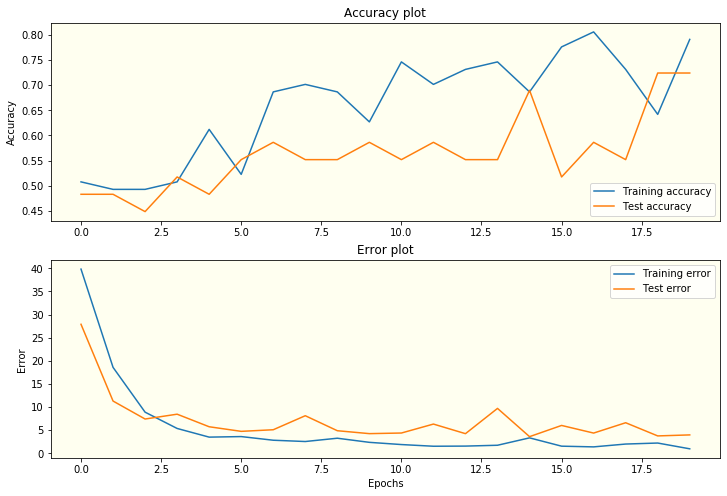

In [8]:
## 6. Plot training curves - NO regularization
plot_history(history, regularization_flag=False)

### Reducing Over-fitting
- 5 techniques
    - Simpler architecture
    - Data-augmentation: Pitch change, Time-stretching, Add noise
    - Early stopping
    - Drop-out
    - Regularization    

- **Drop-out**: NN can't depend on any particular neuron and tries to spread out weights and makes ot robust
- **Regularization**: 
    - Add penalty to error function
    - Punish large weigths
    - L1: Minimize absolute values of weights: $E(p, y) = \frac{1}{2} (p-y)^2 + \lambda \sum |W_i|$
    - L2: Minimize _squared_ values of weights: $E(p, y) = \frac{1}{2} (p-y)^2 + \lambda \sum |W_i|^2$
    - L1: Robust to outliers, simpler model
    - L2: NOT robust to outliers, learns complex patterns

In [9]:
### 1. Load data
X, y = load_data (json_file = JSON_FILE)


### 2. Split into train/test
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.3)

### 3. Build MLP network architecture
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),
    
    # Hidden-layers: With added Dropout amd Regularization with Lambda=0.001
    # 1st hidden-layer:
    keras.layers.Dense(512, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),
    
    # 2nd hidden-layer:
    keras.layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),
    
    # 3rd hidden-layer:
    keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),
    
    # Output layer: NUMBER_OF_CLASSES = number of genres = 4
    #   activation fn. = softmax for normalizing prob. sum to 1.0 and enables us to pick max. prob.
    keras.layers.Dense(NUMBER_OF_CLASSES,  activation="softmax")
])


### 4. Compile network
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, 
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

model.summary()

## 5. Train network. 
#     Use min-batch. Other techniques
#     (1) Stochastic = Gradient on one sample, fast, inaccurate. 
#     (2) Full training set: Very accurate 
#     (3) Mini-batch: in-between

history_reg = model.fit(X_train, y_train,                 # Training data
                        validation_data=(X_test, y_test), # Test data
                        epochs=TRAIN_EPOCHS,
                        batch_size=32)  

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 1080)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               553472    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)               

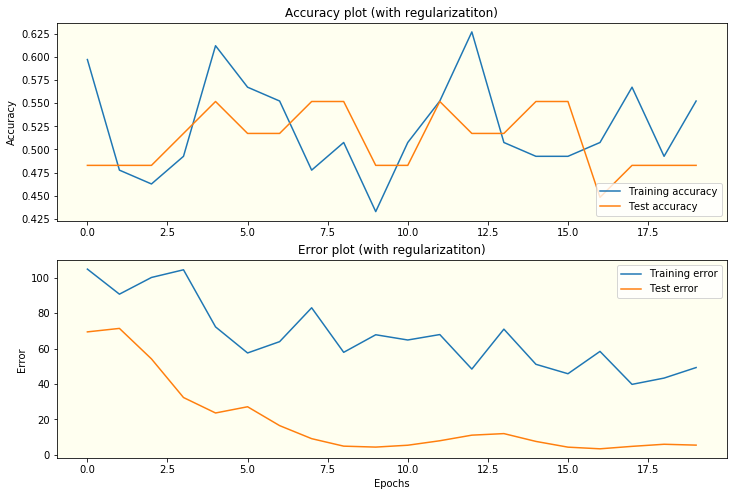

In [10]:
## 6. Plot training curves - With drop-out and L2 regularization
plot_history(history_reg, regularization_flag=True)

In [13]:
import random

## 6. Predict
sample = random.randint(0,19) # Total 20 samples, so select any sample 1-20
X = X_test[sample] 
y = y_test[sample]

predict(model, X, y, JSON_FILE)

Expected machine signal: 'valve_abnormal'. Predicted machine signal: 'valve_normal'
